# <span style="color:pink">Project part 2.5.5</span>

<span style="color:pink">**_Zofia Różańska, 280526_**</span>

<span style="color:pink">_Dataset: Estimation of Obesity Levels Based On Eating Habits and Physical Condition_</span>


In [16]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix

In [18]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

In [19]:
# Load the dataset
dataset_url = 'https://raw.githubusercontent.com/zosia-r/msid/refs/heads/main/I/dataset.csv'
data = pd.read_csv(dataset_url)

# Display all columns and rows in the DataFrame
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print(data.head())

   Gender   Age  Height  Weight family_history_with_overweight FAVC  FCVC  \
0  Female  21.0    1.62    64.0                            yes   no   2.0   
1  Female  21.0    1.52    56.0                            yes   no   3.0   
2    Male  23.0    1.80    77.0                            yes   no   2.0   
3    Male  27.0    1.80    87.0                             no   no   3.0   
4    Male  22.0    1.78    89.8                             no   no   2.0   

   NCP       CAEC SMOKE  CH2O  SCC  FAF  TUE        CALC  \
0  3.0  Sometimes    no   2.0   no  0.0  1.0          no   
1  3.0  Sometimes   yes   3.0  yes  3.0  0.0   Sometimes   
2  3.0  Sometimes    no   2.0   no  2.0  1.0  Frequently   
3  3.0  Sometimes    no   2.0   no  2.0  0.0  Frequently   
4  1.0  Sometimes    no   2.0   no  0.0  0.0   Sometimes   

                  MTRANS           NObeyesdad  
0  Public_Transportation        Normal_Weight  
1  Public_Transportation        Normal_Weight  
2  Public_Transportation        

In [20]:
# Separate features and target
X = data.drop('NObeyesdad', axis=1)
y = data['NObeyesdad']

In [21]:
def preprocess(X):
    # Identify categorical and numerical columns
    categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
    numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

    # Define the preprocessing steps for numerical and categorical features
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ]
    )

    return preprocessor

In [22]:
# Encode the target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [23]:
# Split data into trainig, validating and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.4, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)

In [24]:
# Perform preprocessing on X
preprocessor = preprocess(X)

X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

In [25]:
class LogisticRegression:
    def __init__(self, input_dim, num_classes, lr=0.01):
        self.model = nn.Sequential(
            nn.Linear(input_dim, num_classes),
            nn.Softmax(dim=1)
        )
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.SGD(self.model[0].parameters(), lr=lr, momentum=0.9)

    def evaluate(self, val_loader):
        self.model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for x, y in val_loader:
                logits = self.model[0](x)
                preds = logits.argmax(dim=1)
                correct += (preds == y).sum().item()
                total += y.size(0)
        accuracy = 100. * correct / total
        return accuracy

    def train(self, train_loader, val_loader, epochs=5):
        start_time = time.time()  # Start time for training

        for epoch in range(epochs):
            self.model.train()
            total_loss = 0.0
            for x, y in train_loader:
                self.optimizer.zero_grad()
                logits = self.model[0](x)
                loss = self.criterion(logits, y)
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()

            val_acc = self.evaluate(val_loader)
            print(f"Epoch {epoch + 1} | Train Loss: {total_loss:.4f} | Val Accuracy: {val_acc:.2f}%")

        end_time = time.time()
        total_training_time = end_time - start_time  # Time in seconds

        print(f"\nTraining completed in {total_training_time:.2f} seconds.")

    def save(self, path):
        torch.save(self.model.state_dict(), path)

    def load(self, path):
        self.model.load_state_dict(torch.load(path))
        self.model.eval()

    def predict(self, x):
        self.model.eval()
        with torch.no_grad():
            logits = self.model[0](x)
            preds = logits.argmax(dim=1)
        return preds


In [26]:
# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [27]:
# Create loaders
batch_size = 32

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size)

In [28]:
# Choose device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # no cuda on my pc :(
print("Using device:", device)

Using device: cuda


In [29]:
# Training the model
input_dim = X_train.shape[1]
num_classes = len(np.unique(y_encoded))

model = LogisticRegression(input_dim, num_classes)
model.train(train_loader, val_loader, epochs=1000)

Epoch 1 | Train Loss: 70.0713 | Val Accuracy: 50.00%
Epoch 2 | Train Loss: 52.4440 | Val Accuracy: 56.87%
Epoch 3 | Train Loss: 46.0655 | Val Accuracy: 60.66%
Epoch 4 | Train Loss: 42.8051 | Val Accuracy: 63.74%
Epoch 5 | Train Loss: 40.5060 | Val Accuracy: 65.40%
Epoch 6 | Train Loss: 38.9682 | Val Accuracy: 66.35%
Epoch 7 | Train Loss: 37.5086 | Val Accuracy: 69.19%
Epoch 8 | Train Loss: 36.4830 | Val Accuracy: 70.62%
Epoch 9 | Train Loss: 35.3902 | Val Accuracy: 70.85%
Epoch 10 | Train Loss: 34.5031 | Val Accuracy: 72.75%
Epoch 11 | Train Loss: 33.8370 | Val Accuracy: 71.09%
Epoch 12 | Train Loss: 33.2557 | Val Accuracy: 73.93%
Epoch 13 | Train Loss: 32.6023 | Val Accuracy: 75.12%
Epoch 14 | Train Loss: 32.0190 | Val Accuracy: 75.36%
Epoch 15 | Train Loss: 31.5616 | Val Accuracy: 76.54%
Epoch 16 | Train Loss: 30.9748 | Val Accuracy: 77.01%
Epoch 17 | Train Loss: 30.6087 | Val Accuracy: 77.49%
Epoch 18 | Train Loss: 30.1068 | Val Accuracy: 76.30%
Epoch 19 | Train Loss: 29.8027 | Val 

Accuracy: 93.144%
Classification report:
                      precision    recall  f1-score   support

Insufficient_Weight       0.93      0.96      0.95        55
      Normal_Weight       0.90      0.85      0.88        55
     Obesity_Type_I       0.97      0.96      0.96        69
    Obesity_Type_II       0.98      0.98      0.98        66
   Obesity_Type_III       1.00      1.00      1.00        68
 Overweight_Level_I       0.84      0.85      0.85        55
Overweight_Level_II       0.86      0.87      0.86        55

           accuracy                           0.93       423
          macro avg       0.93      0.93      0.93       423
       weighted avg       0.93      0.93      0.93       423



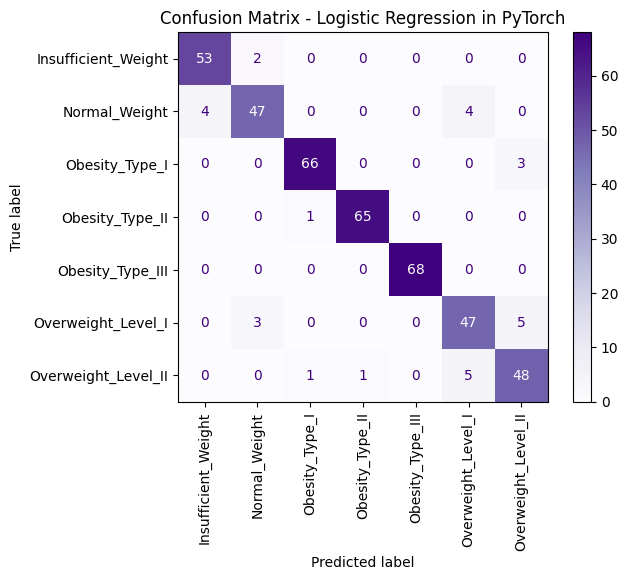

In [30]:
# Evaluate the model
y_pred = model.predict(X_test_tensor)

print(f'Accuracy: {accuracy_score(y_test, y_pred)*100:.3f}%')
print('Classification report:\n', classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(xticks_rotation=90, cmap=plt.cm.Purples)
plt.title('Confusion Matrix - Logistic Regression in PyTorch')
plt.show()